# Task 0: Fashion MNIST classification in Pytorch (10 points)

The goal of this task is to get you familiar with [Pytorch](https://pytorch.org/), teach you to debug your models, and give you a general understanding of deep learning and computer vision work-flows.

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of [Zalando’s](https://jobs.zalando.com/tech/) article images — consisting of 70,000 grayscale images in 10
categories. Each example is a 28x28 grayscale image, associated with a label from 10 classes. ‘Fashion-
MNIST’ is intended to serve as a direct **drop-in replacement** for the original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset — often
used as the “Hello, World” of machine learning programs for computer vision. It shares the same image
size and structure of training and testing splits. We will use 60,000 images to train the network and
10,000 images to evaluate how accurately the network learned to classify images.

### Prerequisites:

- Install [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) and create a conda environment to manage all the packages for the homeworks.
- Install the following packages in your conda environment:
    - [jupyterlab](https://jupyter.org/install) and get familiar with basic operations on jupyter notebook.
    - [Pytorch](https://pytorch.org/)
    - matplotlib
    - tensorboard
    - imageio
    - sklearn

In [1]:
# installation directions can be found on pytorch's webpage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# import our network module from simple_cnn.py
from simple_cnn import SimpleCNN              # be sure to modify or you may have to restart kernel!

Usually you'll parse arguments using `argparse` (or similar library) but we can simply use a stand-in object for ipython notebooks. Furthermore, PyTorch can do computations on NVidia `GPU`s or on normal `CPU`s. You can configure the setting using the `device` variable.

In [2]:
class ARGS(object):
    # input batch size for training 
    batch_size = 64
    # input batch size for testing
    test_batch_size=1000
    # number of epochs to train for
    epochs = 14
    # learning rate
    lr = 0.01
    # Learning rate step gamma
    gamma = 0.7
    # how many batches to wait before logging training status
    log_every = 100
    # how many batches to wait before evaluating model
    val_every = 100
    # set true if using GPU during training
    use_cuda = True

args = ARGS()
device = torch.device("cuda" if args.use_cuda else "cpu")

We define some basic testing and training code. The testing code prints out the average test loss and the training code (`main`) plots train/test losses and returns the final model.

In [3]:
def test(model, device, test_loader):
    """Evaluate model on test dataset."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, correct / len(test_loader.dataset)


def main():
    # 1. load dataset and build dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True)

    # 2. define the model, and optimizer.
    model = SimpleCNN().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args.gamma)
    cnt = 0
    correct = 0
    train_log = {'iter': [], 'loss': [], 'accuracy': []}
    test_log = {'iter': [], 'loss': [], 'accuracy': []}
    for epoch in range(args.epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Get a batch of data
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Calculate the loss
            loss = F.cross_entropy(output, target)
            # Calculate gradient w.r.t the loss
            loss.backward()
            # Optimizer takes one step
            optimizer.step()
            # Log info
            if cnt % args.log_every == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, cnt, len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
                train_log['iter'].append(cnt)
                train_log['loss'].append(loss.cpu().detach().numpy())
                # TODO: q0.1 calculate your train accuracy!
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct = pred.eq(target.view_as(pred)).sum().item()
                train_acc = correct/len(data)
                train_log['accuracy'].append(train_acc)
            # Validation iteration
            if cnt % args.val_every == 0:
                test_loss, test_acc = test(model, device, test_loader)
                test_log['iter'].append(cnt)
                test_log['loss'].append(test_loss)
                test_log['accuracy'].append(test_acc)
                model.train()
            cnt += 1
        scheduler.step()
    fig = plt.figure()
    plt.plot(train_log['iter'], train_log['loss'], 'r', label='Training')
    plt.plot(test_log['iter'], test_log['loss'], 'b', label='Testing')
    plt.title('Loss')
    plt.legend()
    fig = plt.figure()
    plt.plot(train_log['iter'], train_log['accuracy'], 'r', label='Training')
    plt.plot(test_log['iter'], test_log['accuracy'], 'b', label='Testing')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    return model

## 0.1 Bug Fix and Hyper-parameter search. (2pts)

Simply running `main` will result in a `RuntimeError`! 
- (1 pt) Check out `TODO: q0.1` in  `simple_cnn.py` and see if you can fix the bug. You may have to restart your ipython kernel for changes to reflect in the notebook. 
- (1 pt) Fill in the `TODO: q0.1` in the `main()` function above to calculated the train accuracy.


Once you fix the bugs, you should be able to get a reasonable accuracy (>80%) within 100 iterations just by tuning some hyper-parameter. Include the train/test plots of your best hyperparamter setting and comment on why you think these settings worked best. (you can complete this task on CPU)

**ANSWER**

The only hyperparameter I changed here for the learning rate, from 1 to 0.01.

Learning rate of 1 was high, which resulted in unstable training, learning a sub-optimal set of weights too fast. Learning rate of 0.01 worked well within the number of epochs trained

args.batch_size = 64
args.epochs = 14
args.gamma = 0.7
args.log_every = 100
args.lr = 0.01
args.test_batch_size = 1000
args.val_every = 100



Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294190

Test set: Average loss: 11.9956, Accuracy: 1569/10000 (16%)

Train Epoch: 0 [100/60000 (11%)]	Loss: 0.808520

Test set: Average loss: 0.6649, Accuracy: 7538/10000 (75%)

Train Epoch: 0 [200/60000 (21%)]	Loss: 0.392067

Test set: Average loss: 0.5755, Accuracy: 7835/10000 (78%)

Train Epoch: 0 [300/60000 (32%)]	Loss: 0.284539

Test set: Average loss: 0.5114, Accuracy: 8094/10000 (81%)

Train Epoch: 0 [400/60000 (43%)]	Loss: 0.578318

Test set: Average loss: 0.4877, Accuracy: 8234/10000 (82%)

Train Epoch: 0 [500/60000 (53%)]	Loss: 0.824997

Test set: Average loss: 0.4578, Accuracy: 8332/10000 (83%)

Train Epoch: 0 [600/60000 (64%)]	Loss: 0.593107

Test set: Average loss: 0.4567, Accuracy: 8341/10000 (83%)

Train Epoch: 0 [700/60000 (75%)]	Loss: 0.578452

Test set: Average loss: 0.4883, Accuracy: 8233/


Test set: Average loss: 0.2994, Accuracy: 8930/10000 (89%)

Train Epoch: 7 [7400/60000 (89%)]	Loss: 0.358629

Test set: Average loss: 0.3039, Accuracy: 8917/10000 (89%)

Train Epoch: 7 [7500/60000 (100%)]	Loss: 0.228582

Test set: Average loss: 0.3005, Accuracy: 8928/10000 (89%)

Train Epoch: 8 [7600/60000 (10%)]	Loss: 0.168580

Test set: Average loss: 0.2955, Accuracy: 8944/10000 (89%)

Train Epoch: 8 [7700/60000 (21%)]	Loss: 0.223980

Test set: Average loss: 0.2991, Accuracy: 8920/10000 (89%)

Train Epoch: 8 [7800/60000 (32%)]	Loss: 0.150784

Test set: Average loss: 0.2998, Accuracy: 8932/10000 (89%)

Train Epoch: 8 [7900/60000 (42%)]	Loss: 0.270323

Test set: Average loss: 0.2926, Accuracy: 8963/10000 (90%)

Train Epoch: 8 [8000/60000 (53%)]	Loss: 0.225620

Test set: Average loss: 0.2935, Accuracy: 8974/10000 (90%)

Train Epoch: 8 [8100/60000 (64%)]	Loss: 0.196360

Test set: Average loss: 0.2959, Accuracy: 8948/10000 (89%)

Train Epoch: 8 [8200/60000 (74%)]	Loss: 0.307386

Test set

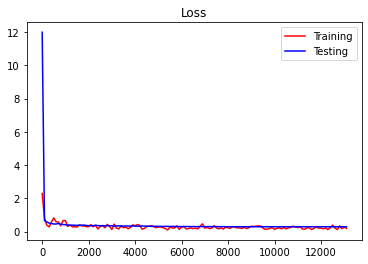

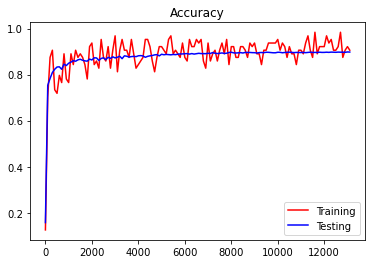

In [4]:
#### FEEL FREE TO MODIFY args VARIABLE HERE OR ABOVE ####
# args.gamma = float('inf')


# DON'T CHANGE
# prints out arguments and runs main
for attr in dir(args):
    if '__' not in attr and attr !='use_cuda':
        print('args.{} = {}'.format(attr, getattr(args, attr)))
print('\n\n')
model = main()

## 0.2 Play with parameters.(3pt)
How many trainable parameters does the trained model have? The answer needs to depend on the input `model` - outputting a constant number will not get any credits. Hint: Find out how to use model.parameters() in PyTorch.

In [5]:
def param_count(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params
print('Model has {} params'.format(param_count(model)))

Model has 454922 params


## 0.3 Deep Linear Networks?!? (5pt)
Until this point, there are no non-linearities in the SimpleCNN! (Your TAs were just as surprised as you are at the results.) Your next task is to modify `simple_cnn.py` to add non-linear activation layers, and train your model in full scale. Make sure to add non-linearities at **every** applicable layer.

Compute the loss and accuracy curves on train and test sets after 5 epochs. The accuracy should be around 90% or higher.

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300396

Test set: Average loss: 10.0728, Accuracy: 1054/10000 (11%)

Train Epoch: 0 [100/60000 (11%)]	Loss: 0.617487

Test set: Average loss: 0.6120, Accuracy: 7588/10000 (76%)

Train Epoch: 0 [200/60000 (21%)]	Loss: 0.775588

Test set: Average loss: 0.4922, Accuracy: 8240/10000 (82%)

Train Epoch: 0 [300/60000 (32%)]	Loss: 0.241022

Test set: Average loss: 0.4668, Accuracy: 8248/10000 (82%)

Train Epoch: 0 [400/60000 (43%)]	Loss: 0.419844

Test set: Average loss: 0.4353, Accuracy: 8397/10000 (84%)

Train Epoch: 0 [500/60000 (53%)]	Loss: 0.533451

Test set: Average loss: 0.4064, Accuracy: 8477/10000 (85%)

Train Epoch: 0 [600/60000 (64%)]	Loss: 0.316395

Test set: Average loss: 0.4246, Accuracy: 8421/10000 (84%)

Train Epoch: 0 [700/60000 (75%)]	Loss: 0.698635

Test set: Average loss: 0.4085, Accuracy: 8473/10000 (85%)

Train Epoch: 0 [800/60000 (85%)]	Loss: 0.323466

Test set: Average loss: 0.3987, Accuracy: 8567/10000 (86%)

Train Epoch: 0 [900/6

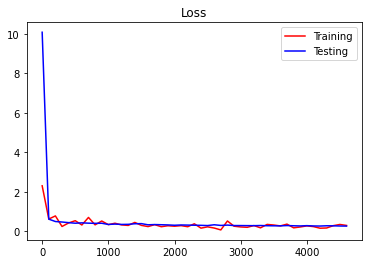

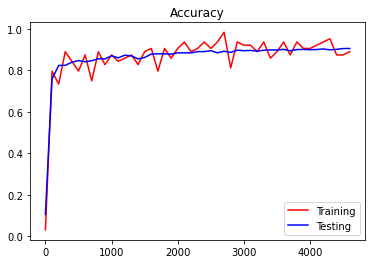

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (nonlinear): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [6]:
args.epochs = 5
main()

Where did you add your non-linearities? 

**ANSWER**

The non-linearities have been put after the first and second convoltutions, and after the first fully connected layer in the Simple CNN model. The non-linear function used is ReLU()

<br><br><br>
Provide some insights on why the results was fairly good even without activation layers. (**2** pts)

**ANSWER**

The activation layers add nonlinearity to the model which helps the network learn complex patterns in the data, but in this case, even without the non linear activation layers, the model performs well on the data. This is probably because the data is linearly separable. This means that the patterns that define this classification work well even when modelled similar to a linear classifier.
